# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Examine portfolio data frame

In [2]:
portfolio.shape

(10, 6)

In [3]:
# there are only ten rows. look at the entire data frame.
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


#### There are no missing entries in portfolio.

In [4]:
# what are the levels of difficulty?
print('there are {} levels of difficulty'.format(portfolio['difficulty'].nunique()))
print('the levels of difficulty are: {}'.format(portfolio['difficulty'].unique().tolist()))

there are 5 levels of difficulty
the levels of difficulty are: [10, 0, 5, 20, 7]


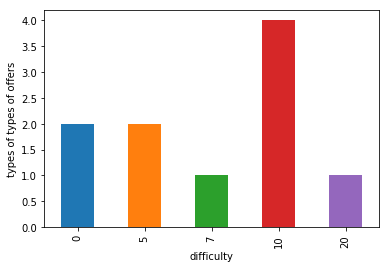

In [5]:
portfolio.groupby('difficulty')['id'].count().plot(kind='bar')
plt.xlabel('difficulty')
plt.ylabel('types of types of offers');

In [6]:
# what are the offer types?
print('there are {} types of offers'.format(portfolio['offer_type'].nunique()))
print('the types of offers are: {}'.format(portfolio['offer_type'].unique().tolist()))

there are 3 types of offers
the types of offers are: ['bogo', 'informational', 'discount']


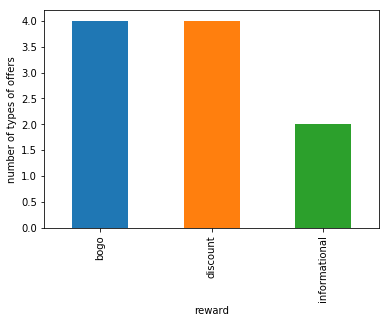

In [7]:
portfolio.groupby('offer_type')['id'].count().plot(kind='bar')
plt.xlabel('reward')
plt.ylabel('number of types of offers');

In [8]:
# what are the reward thresholds?
print('there are {} reward thresholds'.format(portfolio['reward'].nunique()))
print('the reward thresholds are: {}'.format(portfolio['reward'].unique().tolist()))

there are 5 reward thresholds
the reward thresholds are: [10, 0, 5, 3, 2]


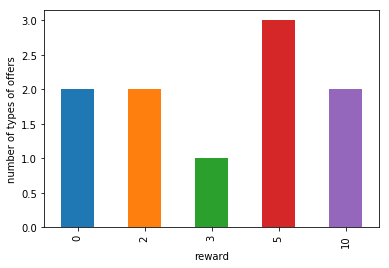

In [9]:
portfolio.groupby('reward')['id'].count().plot(kind='bar')
plt.xlabel('reward')
plt.ylabel('number of types of offers');

In [10]:
# what are the durations?
print('there are {} durations'.format(portfolio['duration'].nunique()))
print('the durations are: {}'.format(portfolio['duration'].unique().tolist()))

there are 5 durations
the durations are: [7, 5, 4, 10, 3]


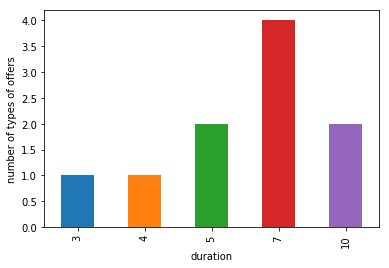

In [11]:
portfolio.groupby('duration')['id'].count().plot(kind='bar')
plt.xlabel('duration')
plt.ylabel('number of types of offers');

In [12]:
# get a list of the channels
channel_list = set()
for channels in portfolio['channels']:
    channel_list.update(channels)

channel_list = list(channel_list)
channel_list

['mobile', 'email', 'web', 'social']

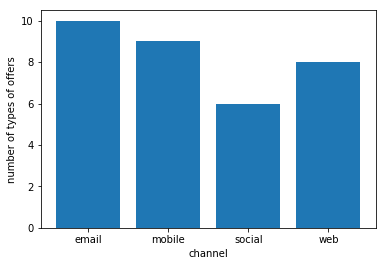

In [13]:
# how many types of offers carry each channel?
channel_freq = dict.fromkeys(channel_list, 0)
for channel in channel_list:
    for offer in portfolio['channels']:
        if channel in offer:
            channel_freq[channel] = channel_freq[channel] + 1
    
plt.bar(channel_freq.keys(), channel_freq.values())
plt.xlabel('channel')
plt.ylabel('number of types of offers');

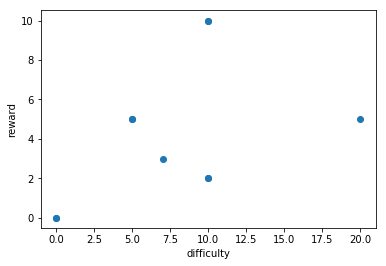

In [14]:
# relationship between difficulty and reward threshold
plt.scatter(portfolio['difficulty'], portfolio['reward'])
plt.xlabel('difficulty')
plt.ylabel('reward');

Roughly speaking, higher difficulty translates into higher reward.

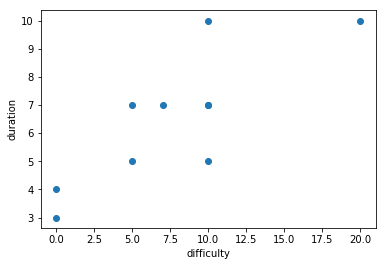

In [15]:
# relationship between difficulty and duration
plt.scatter(portfolio['difficulty'], portfolio['duration'])
plt.xlabel('difficulty')
plt.ylabel('duration');

Roughly speaking, higher difficulty is associated with longer duration.

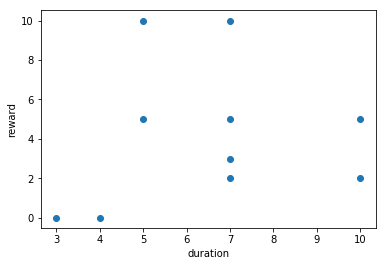

In [16]:
# relationship between duration and reward threshold
plt.scatter(portfolio['duration'], portfolio['reward'])
plt.xlabel('duration')
plt.ylabel('reward');

There is no strong relationship between reward and duration.

## Examine profile data frame

In [17]:
profile.shape

(17000, 5)

In [18]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [19]:
# missing age has been coded as 118. replace 118s by nan. presumably, no custome is 118 years old.
profile['age'] = np.where(profile['age'] == 118, np.nan, profile['age'])

In [20]:
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [21]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.700000e+04,14825.000000
mean,54.393524,2.016703e+07,65404.991568
std,17.383705,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016053e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


Highest income is $120,000. Why aren't there customers with higher incomes in the data set? Were they not targeted?

Age and income may have been input when the customer became a member, and may have not been updated since then.

It will be assumed that the customer entered their date of birth at the time of becoming a member, and Starbuck's system has calculated the age as of the promotion date. If not, the age is incorrect, is a souce of error, and would have to updated as of he promotion date.

If income has not been updated, income could be significantly different, especially for the earliest members, and a source of error in the analysis. It will be assumed that income data is current as of the promotion date.

In [22]:
# how many missing values in each column?
print('there are {} missing values for age'.format(profile.shape[0] - profile['age'].count()))
print('there are {} missing values for became_member_on'.format(profile.shape[0] - profile['became_member_on'].count()))
print('there are {} missing values for income'.format(profile.shape[0] - profile['income'].count()))

there are 2175 missing values for age
there are 0 missing values for became_member_on
there are 2175 missing values for income


In [23]:
# are the missing age and income data in the same rows?
print('{} rows are missing both age and income'.format(profile[(profile['age'].isna()) & (profile['income'].isna())]['became_member_on'].count()))

2175 rows are missing both age and income


If age is missing, so is income, and vice versa.

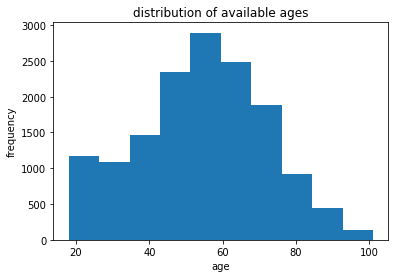

In [24]:
# plot the distribution of available ages
plt.hist(profile['age'].dropna())
plt.title('distribution of available ages')
plt.xlabel('age')
plt.ylabel('frequency');

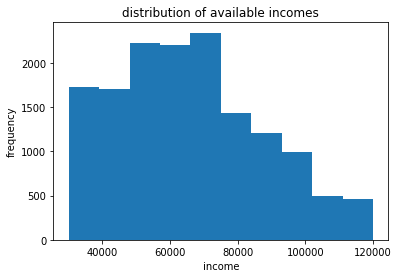

In [25]:
# plot the distribution of available incomes
plt.hist(profile['income'].dropna())
plt.title('distribution of available incomes')
plt.xlabel('income')
plt.ylabel('frequency');

### The age distribution is skewed towards younger customers. If older customers are more reluctant to provide their age, the missing data could have a bias towards older customers. Or, is it that younger customers are more reluctant to provide age and income information? This could affect how we fill in missing age and income values.

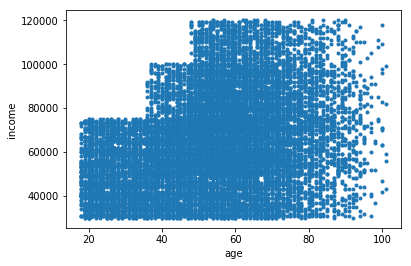

In [26]:
# plot the available incomes against age
plt.scatter(profile['age'].dropna(), profile['income'].dropna(), marker='.')
plt.xlabel('age')
plt.ylabel('income');

In [27]:
# https://www.pewresearch.org/internet/2019/11/15/americans-and-privacy-concerned-confused-and-feeling-lack-of-control-over-their-personal-information/

In [28]:
# create columns for year, month and day became member
profile['became_member_day'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.day
profile['became_member_month'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.month
profile['became_member_year'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.year

In [29]:
profile.head()

,age,became_member_on,gender,id,income,became_member_day,became_member_month,became_member_year
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,12,2,2017
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,15,7,2017
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,12,7,2018
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,9,5,2017
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,4,8,2017


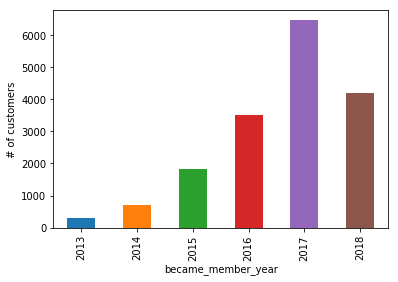

In [30]:
# plot distribution of year in which customers became a member
profile.groupby(['became_member_year'])['id'].count().plot(kind='bar')
plt.ylabel('# of customers');

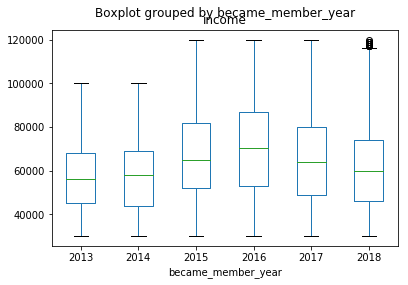

In [31]:
# make a boxplot of income distribution by became_member_year
profile.boxplot(by='became_member_year', column='income', grid=False);

Odd that maximum income in 2013-joiners and 2014-joiners is 100K and jumps to 120K from 2015 onward.

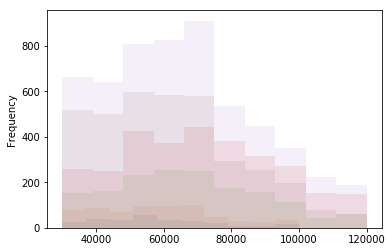

In [32]:
profile.groupby('became_member_year')['income'].plot.hist(alpha=0.1);

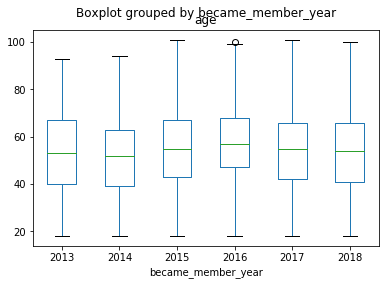

In [33]:
# make a boxplot of age distribution by became_member_year
profile.boxplot(by='became_member_year', column='age', grid=False);

Looks ok.

In [82]:
# get statistics for the gender column
profile['gender'].describe()

count     14825
unique        3
top           M
freq       8484
Name: gender, dtype: object

In [84]:
# what are the values for gender?
print('the values for gender are {}'.format(profile['gender'].unique().tolist()))

the values for gender are [None, 'F', 'M', 'O']


In [93]:
# how many values of each type?
profile.groupby('gender')['id'].count()

gender
F    6129
M    8484
O     212
Name: id, dtype: int64

In [95]:
#There are rows without gender value. Are these the same as the rows without age and income data?
print('{} rows are missing age, income and gender'.format(profile[(profile['gender'].isna()) & (profile['age'].isna()) & (profile['income'].isna())]['became_member_on'].count()))

2175 rows are missing age, income and gender


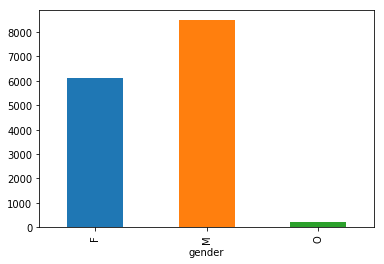

In [98]:
# plot gender distribution
profile.groupby('gender')['id'].count().plot.bar();

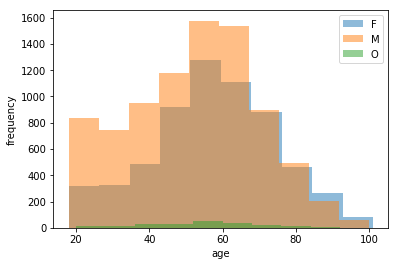

In [105]:
# plot age by gender
profile.groupby('gender')['age'].plot.hist(alpha=0.5)
plt.xlabel('age')
plt.ylabel('frequency')
plt.legend();

There are more males than females in the younger age groups.

As a gender, females are skewed toward higher ages, compared to males.

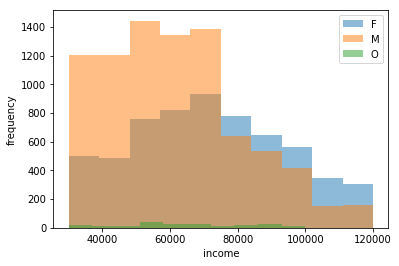

In [107]:
# plot income by gender
profile.groupby('gender')['income'].plot.hist(alpha=0.5)
plt.xlabel('income')
plt.ylabel('frequency')
plt.legend();

There are more males than females in the lower income groups.

Within gender, females are skewed towards higher income compared to males.

## Examine transcript data frame

In [34]:
transcript.shape

(306534, 4)

In [35]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [36]:
# how many missing items in each column?
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no missing entries in this data set.

In [37]:
# how many types of events are there?
print('there are {} possible values for event'.format(transcript['event'].nunique()))
print('the possible values for event are {}'.format(transcript['event'].unique().tolist()))

there are 4 possible values for event
the possible values for event are ['offer received', 'offer viewed', 'transaction', 'offer completed']


In [38]:
# get statistics for the time column (time is in hours)
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

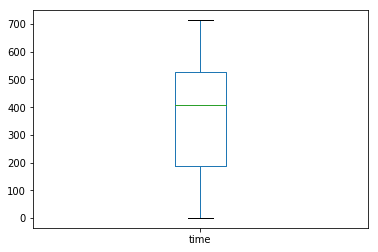

In [39]:
# visualize time distribution as a box plot
transcript.boxplot(column='time', grid=False);

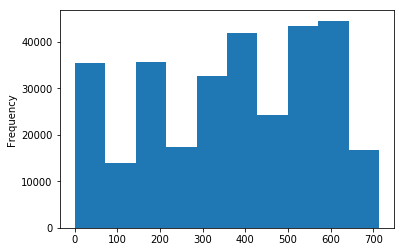

In [40]:
# visualize time distribution as a histogram
transcript['time'].plot.hist();

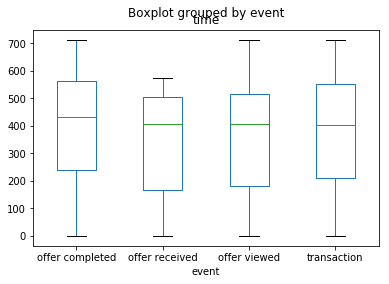

In [41]:
# view time statistics for each type of event
transcript.boxplot(by='event', column='time', grid=False);

In [42]:
# how many persons?
print('the number of unique persons in the transcript data set is {}'.format(transcript['person'].nunique()))
print('the number of unique persons in the profile data set is {}'.format(profile['id'].nunique()))

the number of unique persons in the transcript data set is 17000
the number of unique persons in the profile data set is 17000


In [43]:
# are the persons (ids) the same in both profile and transcripts data sets?
assert set(profile['id']) == set(transcript['person'].unique()), 'the ids are NOT the same in the two data sets'
print('the ids in the two data sets are the same')

the ids in the two data sets are the same


The number of persons in the profile and transcript data sets is the same.

In [44]:
# how many events for each person?
transcript.groupby('person')['event'].count().describe()

count    17000.000000
mean        18.031412
std          6.849595
min          1.000000
25%         13.000000
50%         17.000000
75%         23.000000
max         51.000000
Name: event, dtype: float64

Some persons had only one event. Some had as many as fifty one events. Half the persons (25th to 75th percentile) had between thirteen and twenty three events.

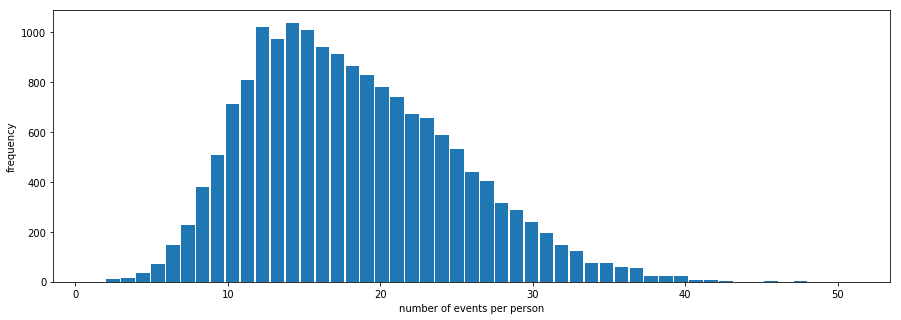

In [45]:
# plot a histogram of number of events per person
plt.figure(figsize=(15,5))
transcript.groupby('person')['event'].count().hist(grid=False, bins=51, rwidth=0.9)
plt.xlabel('number of events per person')
plt.ylabel('frequency');

In [73]:
# pick an arbitrary person. what is the event history? sort by time earlies to latest.
# change the index of the unique series to select a different person
transcript[transcript['person'] == transcript['person'].unique()[0]].sort_values('time')

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [74]:
# look at all the dicts in the value column and make a list of all possible keys
key_list = set()
for value in transcript['value']:
    key_list.update(value.keys())

key_list = list(key_list)
print('the keys are {}'.format(key_list))

the keys are ['offer id', 'reward', 'offer_id', 'amount']


Is the 'offer_id' key the same as the 'offer id' key? Let's look at a few dicts, some with 'offer_id' and some with 'offer id'.

In [75]:
transcript.loc[0]['value']

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [76]:
transcript.loc[15561]['value']

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [77]:
transcript.loc[163375]['value']

{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}

In [78]:
transcript.loc[201572]['value']

{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}

The above dicts have a 'offer id' key. It is the only key/value pair in the dict.

In [79]:
transcript.loc[47583]['value']

{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}

In [80]:
transcript.loc[218394]['value']

{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}

In [81]:
transcript.loc[218395]['value']

{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}

The above dicts have a 'offer_id' key and also another key/value. The second key is 'reward'.

In [114]:
# Add the following columns to the transcript data frame:
# 'offer_id' - contains the offer id or offer_id if there is one, else na;
# 'amount' - contains the amount if there is an amount, else na;
# 'reward' - contains the reward if there is one, else na;



def get_offer_id(row):
    '''
    extracts the value corresponding to the 'offer_id' or 'offer id' key in the input dictionary
    in the 'value' column of the input row
    Input:
        d: (dict) with one of the following structures:
            {'offer id': value}
            {'amount': value}
            {'offer_id': value, 'reward': value}
    Output:
        value for 'offer id' or 'offer_id' key as str, if there is such a key, np.nan otherwise
    '''
    d = row['value']
    if 'offer id' in d:
        return str(d['offer id'])
    elif 'offer_id' in d:
        return str(d['offer_id'])
    else:
        return np.nan
    
def get_amount(row):
    '''
    extracts the value corresponding to the 'amount' key in the input dictionary in the 'value' column
    of the input row
    Input:
        d: (dict) with one of the following structures:
            {'offer id': value}
            {'amount': value}
            {'offer_id': value, 'reward': value}
    Output:
        value for 'amount' key, if there is such a key, np.nan otherwise
    '''
    d = row['value']
    if 'amount' in d:
        return d['amount']
    else:
        return np.nan
        
def get_reward(row):
    '''
    extracts the value corresponding to the 'amount' key in the input dictionary in the 'value' column
    of the input row
    Input:
        d: (dict) with one of the following structures:
            {'offer id': value}
            {'amount': value}
            {'offer_id': value, 'reward': value}
    Output:
        value for 'reward' key, if there is such a key, np.nan otherwise
    '''
    d = row['value']
    if 'reward' in d:
        return d['reward']
    else:
        return np.nan
    
transcript['offer_id'] = transcript.apply(get_offer_id, axis=1)
transcript['amount'] = transcript.apply(get_amount, axis=1)
transcript['reward'] = transcript.apply(get_reward, axis=1)

In [115]:
transcript.head()

,event,person,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [146]:
# check if the values in the 'offer_id' column of transcript are the same as the values in the 'id' column of portfolio.
# first, remove the nan (if any) from the set of values in the 'offer_id' column in transcript. there probably will be nan
# in the set from the 'reward' and 'amount' keys in the 'value' column.

# create a set of the values in the 'offer_id' column in transcript
s = set(transcript['offer_id'].unique())
# remove nan exploiting that in python nan != nan
{e for e in s if e  == e}

assert {e for e in s if e  == e} == set(portfolio['id'].unique()), 'They are DIFFERENT'
print('They are the SAME.')

They are the SAME.
